### Here I'll show how you can build multiple models, ensemble but also evaluate each of them, this may help instead of just train random models and then blindly submit the results.

#### This is another iteration of the amazing work of Chris Deotte [checkout here](https://www.kaggle.com/cdeotte/support-vector-machine-0-925)

# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC, NuSVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

%matplotlib inline
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# Model

## Model parameters

In [3]:
N_FOLDS = 5

### You can find evaluation metrics for each model on each fold below on this cell output log. (It's hidden to keep the code clean)

In [4]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic', 'preds']]
test['target_knn'] = 0
train['preds_knn'] = 0
test['target_mlp'] = 0
train['preds_mlp'] = 0
test['target_svc'] = 0
train['preds_svc'] = 0
test['target_nusvc'] = 0
train['preds_nusvc'] = 0
test['target_qda'] = 0
train['preds_qda'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = StandardScaler().fit_transform(PCA(svd_solver='full',n_components='mle').fit_transform(data[cols]))
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model_names = ['knn', 'mlp', 'svc', 'nusvc', 'qda']
        models = [KNeighborsClassifier(n_neighbors=17, p=2.9), 
                  MLPClassifier(random_state=3, activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(250, )), 
                  SVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=42), 
                  NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053), 
                  QuadraticDiscriminantAnalysis(0.1)]
        
        for i in range(len(model_names)):
            model = models[i]
            model_name = model_names[i]
            model.fit(train3[train_index,:], train2.loc[train_index]['target'])

            train_predictions = model.predict(train3[train_index,:])
            val_predictions = model.predict(train3[val_index,:])

            train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
            val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
            train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
            val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
            train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
            val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
            print('-----%s - Train----------' % model_name)
            print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
            print('-----%s - Validation-----' % model_name)
            print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

            # Make predictions
            train[('preds_%s' % model_name)].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
            test[('target_%s' % model_name)].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----knn - Train----------
AUC: 87.51 Precision: 90.26 Recall: 83.81 

-----knn - Validation-----
AUC: 78.47 Precision: 87.50 Recall: 66.04 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 81.44 Precision: 82.35 Recall: 79.25 

-----svc - Train----------
AUC: 99.29 Precision: 100.00 Recall: 98.57 

-----svc - Validation-----
AUC: 75.57 Precision: 90.91 Recall: 56.60 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 78.37 Precision: 94.12 Recall: 60.38 

-----qda - Train----------
AUC: 97.65 Precision: 98.08 Recall: 97.14 

-----qda - Validation-----
AUC: 88.85 Precision: 90.20 Recall: 86.79 

Fold 2

-----knn - Train----------
AUC: 82.98 Precision: 90.59 Recall: 73.33 

-----knn - Validation-----
AUC: 85.92 Precision: 91.30 Recall: 79.25 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Valida

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 84.97 Precision: 85.42 Recall: 83.67 

-----svc - Train----------
AUC: 98.97 Precision: 100.00 Recall: 97.94 

-----svc - Validation-----
AUC: 74.61 Precision: 90.00 Recall: 55.10 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 93.96 Precision: 95.74 Recall: 91.84 

-----qda - Train----------
AUC: 98.23 Precision: 97.95 Recall: 98.45 

-----qda - Validation-----
AUC: 89.06 Precision: 86.54 Recall: 91.84 

Fold 3

-----knn - Train----------
AUC: 87.07 Precision: 88.65 Recall: 84.54 

-----knn - Validation-----
AUC: 77.73 Precision: 80.00 Recall: 73.47 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 73.76 Precision: 72.55 Recall: 75.51 

-----svc - Train----------
AUC: 98.97 Precision: 100.00 Recall: 97.94 

-----svc - Validation-----
AUC: 86.82 Precision: 90.91

-----svc - Train----------
AUC: 99.02 Precision: 98.12 Recall: 100.00 

-----svc - Validation-----
AUC: 74.55 Precision: 67.57 Recall: 96.15 

-----nusvc - Train----------
AUC: 99.75 Precision: 99.52 Recall: 100.00 

-----nusvc - Validation-----
AUC: 88.27 Precision: 83.33 Recall: 96.15 

-----qda - Train----------
AUC: 97.58 Precision: 98.07 Recall: 97.13 

-----qda - Validation-----
AUC: 89.29 Precision: 87.27 Recall: 92.31 

Fold 4

-----knn - Train----------
AUC: 89.59 Precision: 89.90 Recall: 89.47 

-----knn - Validation-----
AUC: 88.33 Precision: 87.04 Recall: 90.38 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 85.35 Precision: 80.33 Recall: 94.23 

-----svc - Train----------
AUC: 99.02 Precision: 98.12 Recall: 100.00 

-----svc - Validation-----
AUC: 83.35 Precision: 76.12 Recall: 98.08 

-----nusvc - Train----------
AUC: 99.51 Precision: 99.05 Recall: 100.00 

-----nusvc - Validation-----
AUC: 90.21 Precision: 85.00

-----nusvc - Train----------
AUC: 99.26 Precision: 98.60 Recall: 100.00 

-----nusvc - Validation-----
AUC: 83.00 Precision: 75.71 Recall: 100.00 

-----qda - Train----------
AUC: 97.34 Precision: 97.18 Recall: 97.64 

-----qda - Validation-----
AUC: 96.17 Precision: 98.04 Recall: 94.34 

Fold 5

-----knn - Train----------
AUC: 92.00 Precision: 90.50 Recall: 94.34 

-----knn - Validation-----
AUC: 85.11 Precision: 79.69 Recall: 96.23 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 84.34 Precision: 82.46 Recall: 88.68 

-----svc - Train----------
AUC: 98.77 Precision: 97.70 Recall: 100.00 

-----svc - Validation-----
AUC: 81.06 Precision: 74.29 Recall: 98.11 

-----nusvc - Train----------
AUC: 99.75 Precision: 99.53 Recall: 100.00 

-----nusvc - Validation-----
AUC: 83.06 Precision: 76.47 Recall: 98.11 

-----qda - Train----------
AUC: 98.80 Precision: 99.05 Recall: 98.58 

-----qda - Validation-----
AUC: 94.23 Precision: 96.08

wheezy-copper-turtle-magic 9

Fold 1

-----knn - Train----------
AUC: 83.18 Precision: 75.93 Recall: 97.16 

-----knn - Validation-----
AUC: 74.53 Precision: 68.06 Recall: 92.45 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 80.19 Precision: 84.78 Recall: 73.58 

-----svc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----svc - Validation-----
AUC: 80.19 Precision: 71.62 Recall: 100.00 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 85.85 Precision: 79.69 Recall: 96.23 

-----qda - Train----------
AUC: 98.10 Precision: 99.03 Recall: 97.16 

-----qda - Validation-----
AUC: 94.34 Precision: 94.34 Recall: 94.34 

Fold 2

-----knn - Train----------
AUC: 79.62 Precision: 72.08 Recall: 96.68 

-----knn - Validation-----
AUC: 71.70 Precision: 64.56 Recall: 96.23 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Val

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 80.55 Precision: 76.92 Recall: 85.11 

-----svc - Train----------
AUC: 99.73 Precision: 100.00 Recall: 99.46 

-----svc - Validation-----
AUC: 80.85 Precision: 100.00 Recall: 61.70 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 92.62 Precision: 97.62 Recall: 87.23 

-----qda - Train----------
AUC: 98.48 Precision: 97.35 Recall: 99.46 

-----qda - Validation-----
AUC: 93.74 Precision: 95.56 Recall: 91.49 

Fold 3

-----knn - Train----------
AUC: 92.95 Precision: 93.92 Recall: 91.40 

-----knn - Validation-----
AUC: 90.65 Precision: 89.36 Recall: 91.30 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 80.30 Precision: 77.55 Recall: 82.61 

-----svc - Train----------
AUC: 99.73 Precision: 100.00 Recall: 99.46 

-----svc - Validation-----
AUC: 72.91 Precision: 95.6

-----svc - Train----------
AUC: 99.20 Precision: 100.00 Recall: 98.40 

-----svc - Validation-----
AUC: 74.53 Precision: 96.00 Recall: 51.06 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 82.04 Precision: 94.12 Recall: 68.09 

-----qda - Train----------
AUC: 97.94 Precision: 97.87 Recall: 97.87 

-----qda - Validation-----
AUC: 95.87 Precision: 95.74 Recall: 95.74 

Fold 4

-----knn - Train----------
AUC: 84.30 Precision: 90.00 Recall: 76.60 

-----knn - Validation-----
AUC: 83.23 Precision: 89.74 Recall: 74.47 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 84.49 Precision: 84.78 Recall: 82.98 

-----svc - Train----------
AUC: 98.67 Precision: 100.00 Recall: 97.34 

-----svc - Validation-----
AUC: 71.28 Precision: 100.00 Recall: 42.55 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 79.91 Precision: 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 92.31 Precision: 100.00 Recall: 84.62 

-----qda - Train----------
AUC: 98.55 Precision: 98.56 Recall: 98.56 

-----qda - Validation-----
AUC: 94.19 Precision: 96.00 Recall: 92.31 

Fold 5

-----knn - Train----------
AUC: 91.01 Precision: 89.45 Recall: 93.30 

-----knn - Validation-----
AUC: 80.47 Precision: 75.00 Recall: 92.31 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 83.50 Precision: 84.31 Recall: 82.69 

-----svc - Train----------
AUC: 99.75 Precision: 99.52 Recall: 100.00 

-----svc - Validation-----
AUC: 82.39 Precision: 75.76 Recall: 96.15 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 84.41 Precision: 81.03 Recall: 90.38 

-----qda - Train----------
AUC: 98.55 Precision: 99.03 Recall: 98.09 

-----qda - Validation-----
AUC: 89.29 Precision: 8

wheezy-copper-turtle-magic 18

Fold 1

-----knn - Train----------
AUC: 88.82 Precision: 87.39 Recall: 91.51 

-----knn - Validation-----
AUC: 86.61 Precision: 89.80 Recall: 83.02 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 84.72 Precision: 89.36 Recall: 79.25 

-----svc - Train----------
AUC: 99.50 Precision: 99.07 Recall: 100.00 

-----svc - Validation-----
AUC: 77.52 Precision: 70.83 Recall: 96.23 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 88.31 Precision: 83.61 Recall: 96.23 

-----qda - Train----------
AUC: 99.03 Precision: 99.06 Recall: 99.06 

-----qda - Validation-----
AUC: 93.29 Precision: 94.23 Recall: 92.45 

Fold 2

-----knn - Train----------
AUC: 89.59 Precision: 89.30 Recall: 90.57 

-----knn - Validation-----
AUC: 81.59 Precision: 78.33 Recall: 88.68 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Valid

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 82.40 Precision: 80.39 Recall: 83.67 

-----svc - Train----------
AUC: 99.75 Precision: 100.00 Recall: 99.49 

-----svc - Validation-----
AUC: 80.92 Precision: 89.47 Recall: 69.39 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 87.12 Precision: 89.13 Recall: 83.67 

-----qda - Train----------
AUC: 98.06 Precision: 97.49 Recall: 98.48 

-----qda - Validation-----
AUC: 89.39 Precision: 85.19 Recall: 93.88 

Fold 3

-----knn - Train----------
AUC: 86.69 Precision: 88.65 Recall: 83.25 

-----knn - Validation-----
AUC: 77.07 Precision: 82.50 Recall: 67.35 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 89.01 Precision: 93.18 Recall: 83.67 

-----svc - Train----------
AUC: 99.75 Precision: 100.00 Recall: 99.49 

-----svc - Validation-----
AUC: 82.65 Precision: 100.0

-----svc - Train----------
AUC: 98.56 Precision: 97.37 Recall: 100.00 

-----svc - Validation-----
AUC: 76.98 Precision: 70.13 Recall: 98.18 

-----nusvc - Train----------
AUC: 99.52 Precision: 99.11 Recall: 100.00 

-----nusvc - Validation-----
AUC: 89.48 Precision: 84.38 Recall: 98.18 

-----qda - Train----------
AUC: 98.38 Precision: 98.64 Recall: 98.20 

-----qda - Validation-----
AUC: 95.35 Precision: 96.30 Recall: 94.55 

Fold 4

-----knn - Train----------
AUC: 91.02 Precision: 88.33 Recall: 95.50 

-----knn - Validation-----
AUC: 82.10 Precision: 80.00 Recall: 87.27 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 83.06 Precision: 81.36 Recall: 87.27 

-----svc - Train----------
AUC: 98.80 Precision: 97.80 Recall: 100.00 

-----svc - Validation-----
AUC: 72.12 Precision: 65.48 Recall: 100.00 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 80.87 Precision: 74

-----nusvc - Train----------
AUC: 99.47 Precision: 100.00 Recall: 98.93 

-----nusvc - Validation-----
AUC: 68.48 Precision: 100.00 Recall: 36.96 

-----qda - Train----------
AUC: 98.48 Precision: 98.40 Recall: 98.40 

-----qda - Validation-----
AUC: 95.65 Precision: 100.00 Recall: 91.30 

Fold 5

-----knn - Train----------
AUC: 89.98 Precision: 92.05 Recall: 86.63 

-----knn - Validation-----
AUC: 82.02 Precision: 89.19 Recall: 71.74 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 89.51 Precision: 92.86 Recall: 84.78 

-----svc - Train----------
AUC: 93.85 Precision: 100.00 Recall: 87.70 

-----svc - Validation-----
AUC: 57.73 Precision: 88.89 Recall: 17.39 

-----nusvc - Train----------
AUC: 98.93 Precision: 100.00 Recall: 97.86 

-----nusvc - Validation-----
AUC: 66.43 Precision: 94.12 Recall: 34.78 

-----qda - Train----------
AUC: 99.05 Precision: 97.91 Recall: 100.00 

-----qda - Validation-----
AUC: 90.47 Precision: 95.

wheezy-copper-turtle-magic 27

Fold 1

-----knn - Train----------
AUC: 86.68 Precision: 87.43 Recall: 84.21 

-----knn - Validation-----
AUC: 85.76 Precision: 92.50 Recall: 77.08 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 74.31 Precision: 73.91 Recall: 70.83 

-----svc - Train----------
AUC: 98.16 Precision: 100.00 Recall: 96.32 

-----svc - Validation-----
AUC: 66.67 Precision: 100.00 Recall: 33.33 

-----nusvc - Train----------
AUC: 99.21 Precision: 100.00 Recall: 98.42 

-----nusvc - Validation-----
AUC: 79.28 Precision: 96.67 Recall: 60.42 

-----qda - Train----------
AUC: 97.59 Precision: 95.92 Recall: 98.95 

-----qda - Validation-----
AUC: 92.94 Precision: 95.56 Recall: 89.58 

Fold 2

-----knn - Train----------
AUC: 86.49 Precision: 83.25 Recall: 88.95 

-----knn - Validation-----
AUC: 85.26 Precision: 82.35 Recall: 87.50 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Valida

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 81.00 Precision: 84.44 Recall: 76.00 

-----svc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----svc - Validation-----
AUC: 92.00 Precision: 92.00 Recall: 92.00 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 90.00 Precision: 85.71 Recall: 96.00 

-----qda - Train----------
AUC: 98.24 Precision: 97.54 Recall: 99.00 

-----qda - Validation-----
AUC: 89.00 Precision: 89.80 Recall: 88.00 

Fold 3

-----knn - Train----------
AUC: 86.89 Precision: 81.09 Recall: 96.50 

-----knn - Validation-----
AUC: 84.00 Precision: 79.31 Recall: 92.00 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 88.00 Precision: 85.19 Recall: 92.00 

-----svc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----svc - Validation-----
AUC: 92.00 Precision: 9

-----svc - Train----------
AUC: 99.50 Precision: 100.00 Recall: 99.00 

-----svc - Validation-----
AUC: 74.04 Precision: 96.15 Recall: 50.00 

-----nusvc - Train----------
AUC: 99.75 Precision: 100.00 Recall: 99.50 

-----nusvc - Validation-----
AUC: 80.08 Precision: 94.12 Recall: 64.00 

-----qda - Train----------
AUC: 97.55 Precision: 97.04 Recall: 98.01 

-----qda - Validation-----
AUC: 91.15 Precision: 91.84 Recall: 90.00 

Fold 4

-----knn - Train----------
AUC: 87.52 Precision: 86.41 Recall: 88.56 

-----knn - Validation-----
AUC: 76.16 Precision: 80.95 Recall: 68.00 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 73.27 Precision: 72.55 Recall: 74.00 

-----svc - Train----------
AUC: 99.50 Precision: 100.00 Recall: 99.00 

-----svc - Validation-----
AUC: 79.04 Precision: 93.94 Recall: 62.00 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 91.04 Precision: 95.

-----nusvc - Train----------
AUC: 99.76 Precision: 99.54 Recall: 100.00 

-----nusvc - Validation-----
AUC: 88.50 Precision: 83.61 Recall: 96.23 

-----qda - Train----------
AUC: 96.94 Precision: 97.64 Recall: 96.28 

-----qda - Validation-----
AUC: 94.29 Precision: 94.34 Recall: 94.34 

Fold 5

-----knn - Train----------
AUC: 89.59 Precision: 89.40 Recall: 90.23 

-----knn - Validation-----
AUC: 84.81 Precision: 89.36 Recall: 79.25 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 80.93 Precision: 80.00 Recall: 83.02 

-----svc - Train----------
AUC: 97.12 Precision: 94.71 Recall: 100.00 

-----svc - Validation-----
AUC: 72.13 Precision: 65.00 Recall: 98.11 

-----nusvc - Train----------
AUC: 99.52 Precision: 99.08 Recall: 100.00 

-----nusvc - Validation-----
AUC: 80.82 Precision: 74.63 Recall: 94.34 

-----qda - Train----------
AUC: 97.63 Precision: 97.24 Recall: 98.14 

-----qda - Validation-----
AUC: 93.34 Precision: 94.23 

-----qda - Train----------
AUC: 98.28 Precision: 98.54 Recall: 98.07 

-----qda - Validation-----
AUC: 90.00 Precision: 90.20 Recall: 90.20 

wheezy-copper-turtle-magic 36

Fold 1

-----knn - Train----------
AUC: 85.83 Precision: 92.11 Recall: 77.35 

-----knn - Validation-----
AUC: 80.58 Precision: 96.67 Recall: 63.04 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 79.55 Precision: 79.55 Recall: 76.09 

-----svc - Train----------
AUC: 92.82 Precision: 100.00 Recall: 85.64 

-----svc - Validation-----
AUC: 57.61 Precision: 100.00 Recall: 15.22 

-----nusvc - Train----------
AUC: 98.62 Precision: 100.00 Recall: 97.24 

-----nusvc - Validation-----
AUC: 69.57 Precision: 100.00 Recall: 39.13 

-----qda - Train----------
AUC: 98.18 Precision: 98.33 Recall: 97.79 

-----qda - Validation-----
AUC: 90.65 Precision: 93.02 Recall: 86.96 

Fold 2

-----knn - Train----------
AUC: 81.37 Precision: 96.69 Recall: 64.64 

-----knn - Validati

Fold 2

-----knn - Train----------
AUC: 90.67 Precision: 90.82 Recall: 89.45 

-----knn - Validation-----
AUC: 73.50 Precision: 72.00 Recall: 72.00 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 75.39 Precision: 74.00 Recall: 74.00 

-----svc - Train----------
AUC: 95.73 Precision: 100.00 Recall: 91.46 

-----svc - Validation-----
AUC: 60.11 Precision: 91.67 Recall: 22.00 

-----nusvc - Train----------
AUC: 99.50 Precision: 100.00 Recall: 98.99 

-----nusvc - Validation-----
AUC: 75.11 Precision: 96.30 Recall: 52.00 

-----qda - Train----------
AUC: 99.75 Precision: 100.00 Recall: 99.50 

-----qda - Validation-----
AUC: 92.32 Precision: 93.75 Recall: 90.00 

Fold 3

-----knn - Train----------
AUC: 86.49 Precision: 84.80 Recall: 86.93 

-----knn - Validation-----
AUC: 86.96 Precision: 83.33 Recall: 90.00 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 83.75 Precision:

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 79.78 Precision: 80.85 Recall: 77.55 

-----svc - Train----------
AUC: 95.98 Precision: 92.49 Recall: 100.00 

-----svc - Validation-----
AUC: 64.98 Precision: 58.54 Recall: 97.96 

-----nusvc - Train----------
AUC: 99.25 Precision: 98.50 Recall: 100.00 

-----nusvc - Validation-----
AUC: 70.96 Precision: 63.51 Recall: 95.92 

-----qda - Train----------
AUC: 97.48 Precision: 96.98 Recall: 97.97 

-----qda - Validation-----
AUC: 88.88 Precision: 89.58 Recall: 87.76 

Fold 4

-----knn - Train----------
AUC: 86.65 Precision: 82.43 Recall: 92.89 

-----knn - Validation-----
AUC: 83.98 Precision: 76.19 Recall: 97.96 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 87.88 Precision: 87.76 Recall: 87.76 

-----svc - Train----------
AUC: 99.25 Precision: 98.50 Recall: 100.00 

-----svc - Validation-----
AUC: 83.98 Precision: 76.19 R

-----svc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----svc - Validation-----
AUC: 90.43 Precision: 89.58 Recall: 91.49 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 91.49 Precision: 86.79 Recall: 97.87 

-----qda - Train----------
AUC: 98.41 Precision: 98.42 Recall: 98.42 

-----qda - Validation-----
AUC: 93.62 Precision: 91.84 Recall: 95.74 

Fold 5

-----knn - Train----------
AUC: 85.95 Precision: 82.16 Recall: 92.11 

-----knn - Validation-----
AUC: 86.01 Precision: 85.42 Recall: 87.23 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 89.25 Precision: 89.36 Recall: 89.36 

-----svc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----svc - Validation-----
AUC: 90.38 Precision: 95.24 Recall: 85.11 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 92.51 Precisio

-----nusvc - Train----------
AUC: 99.74 Precision: 99.53 Recall: 100.00 

-----nusvc - Validation-----
AUC: 84.25 Precision: 79.37 Recall: 96.15 

-----qda - Train----------
AUC: 98.97 Precision: 98.60 Recall: 99.53 

-----qda - Validation-----
AUC: 90.83 Precision: 90.57 Recall: 92.31 

wheezy-copper-turtle-magic 45

Fold 1

-----knn - Train----------
AUC: 87.50 Precision: 86.89 Recall: 87.75 

-----knn - Validation-----
AUC: 78.76 Precision: 80.85 Recall: 74.51 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 81.71 Precision: 82.00 Recall: 80.39 

-----svc - Train----------
AUC: 99.53 Precision: 99.03 Recall: 100.00 

-----svc - Validation-----
AUC: 85.74 Precision: 80.00 Recall: 94.12 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 90.42 Precision: 88.68 Recall: 92.16 

-----qda - Train----------
AUC: 96.64 Precision: 96.12 Recall: 97.06 

-----qda - Validation-

-----qda - Train----------
AUC: 98.57 Precision: 99.07 Recall: 98.15 

-----qda - Validation-----
AUC: 88.55 Precision: 89.09 Recall: 89.09 

Fold 2

-----knn - Train----------
AUC: 86.58 Precision: 88.15 Recall: 85.71 

-----knn - Validation-----
AUC: 79.04 Precision: 83.33 Recall: 74.07 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 75.89 Precision: 76.36 Recall: 77.78 

-----svc - Train----------
AUC: 96.48 Precision: 93.94 Recall: 100.00 

-----svc - Validation-----
AUC: 69.07 Precision: 63.86 Recall: 98.15 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 89.07 Precision: 84.13 Recall: 98.15 

-----qda - Train----------
AUC: 98.11 Precision: 99.06 Recall: 97.24 

-----qda - Validation-----
AUC: 94.15 Precision: 92.86 Recall: 96.30 

Fold 3

-----knn - Train----------
AUC: 87.64 Precision: 87.05 Recall: 89.86 

-----knn - Validation-----
AUC: 86.22 Precision: 8

Fold 3

-----knn - Train----------
AUC: 87.49 Precision: 91.26 Recall: 82.67 

-----knn - Validation-----
AUC: 84.19 Precision: 88.64 Recall: 78.00 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 84.31 Precision: 84.00 Recall: 84.00 

-----svc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----svc - Validation-----
AUC: 92.23 Precision: 88.89 Recall: 96.00 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 91.12 Precision: 93.62 Recall: 88.00 

-----qda - Train----------
AUC: 97.81 Precision: 97.54 Recall: 98.02 

-----qda - Validation-----
AUC: 94.15 Precision: 92.31 Recall: 96.00 

Fold 4

-----knn - Train----------
AUC: 85.74 Precision: 92.35 Recall: 77.72 

-----knn - Validation-----
AUC: 84.15 Precision: 90.48 Recall: 76.00 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 85.23 Precisi

# Ensemble models

Here you can ensemble any combination of models, and give the desired weight for each one.

In [5]:
train['preds_svcs'] = (train['preds_svc'] * 0.5) + (train['preds_nusvc'] * 0.5)
test['target_svcs'] = (test['target_svc'] * 0.5) + (test['target_nusvc'] * 0.5)

train['preds_avg'] = (train['preds_knn'] * 0.2) + (train['preds_mlp'] * 0.2) + (train['preds_svc'] * 0.2) + (train['preds_nusvc'] * 0.2) + (train['preds_qda'] * 0.2)
test['target_avg'] = (test['target_knn'] * 0.2) + (test['target_mlp'] * 0.2) + (test['target_svc'] * 0.2) + (test['target_nusvc'] * 0.2) + (test['target_qda'] * 0.2)

train['preds_avg2'] = (train['preds_knn'] * 0.2) + (train['preds_mlp'] * 0.05) + (train['preds_svc'] * 0.05) + (train['preds_nusvc'] * 0.7)
test['target_avg2'] = (test['target_knn'] * 0.2) + (test['target_mlp'] * 0.05) + (test['target_svc'] * 0.05) + (test['target_nusvc'] * 0.7)


# Model evaluation
## Confusion matrix (averaged model)

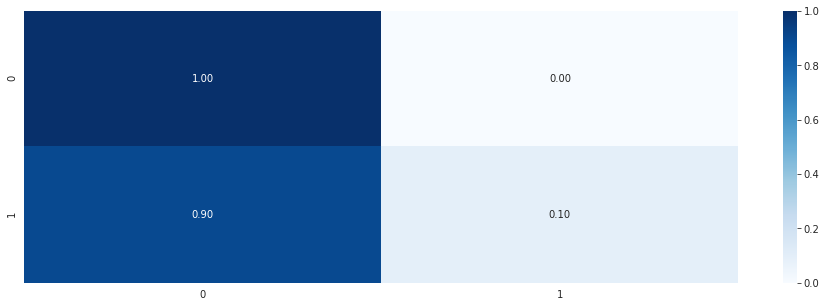

In [6]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_avg']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Confusion matrix (knn model)

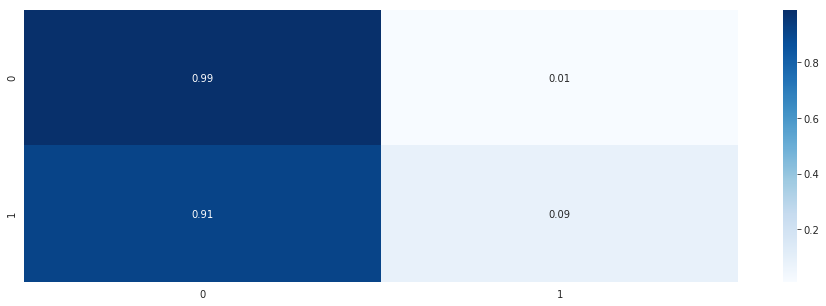

In [7]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_knn']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Confusion matrix (SVC model)

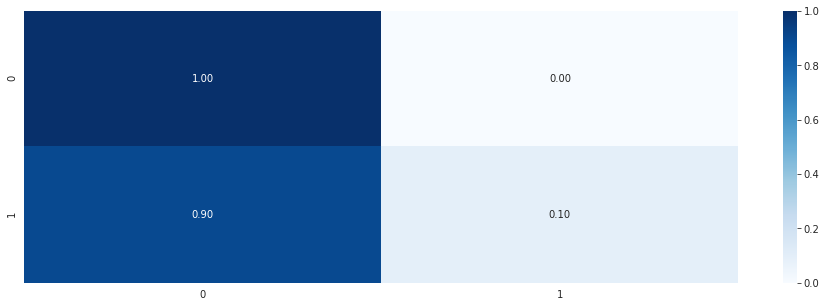

In [8]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_svc']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Metrics ROC AUC

In [9]:
print('KNN AUC %.2f' % roc_auc_score(train['target'], train['preds_knn']))
print('MLP AUC %.2f' % roc_auc_score(train['target'], train['preds_mlp']))
print('SVC AUC %.2f' % roc_auc_score(train['target'], train['preds_svc']))
print('NuSVC AUC %.2f' % roc_auc_score(train['target'], train['preds_nusvc']))
print('QDA AUC %.2f' % roc_auc_score(train['target'], train['preds_qda']))
print('SVCs AUC %.2f' % roc_auc_score(train['target'], train['preds_svcs']))
print('Averaged AUC %.2f' % roc_auc_score(train['target'], train['preds_avg']))
print('Averaged 2 AUC %.2f' % roc_auc_score(train['target'], train['preds_avg2']))

KNN AUC 0.50
MLP AUC 0.50
SVC AUC 0.50
NuSVC AUC 0.50
QDA AUC 0.50
SVCs AUC 0.50
Averaged AUC 0.50
Averaged 2 AUC 0.50


### Test set with all models predictions

In [10]:
test[['id', 'target_avg', 'target_avg2', 'target_svcs', 'target_knn', 'target_mlp', 'target_svc', 'target_nusvc', 'target_qda']].head()

,id,target_avg,target_avg2,target_svcs,target_knn,target_mlp,target_svc,target_nusvc,target_qda
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.377118,0.556601,0.606916,0.470588,0.032597,0.598199,0.615634,0.168574
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Test predictions
Now you can output predictions for each individual model and the ensembled models as well.

#### Averaged models submission

In [11]:
submission = test[['id', 'target_avg']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.377118
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### Averaged 2 models submission

In [12]:
submission = test[['id', 'target_avg2']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg2.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.556601
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### SVCs models submission

In [13]:
submission = test[['id', 'target_svcs']]
submission.columns = ['id', 'target']
submission.to_csv('submission_svcs.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.606916
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### KNN model submission

In [14]:
submission = test[['id', 'target_knn']]
submission.columns = ['id', 'target']
submission.to_csv('submission_knn.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.470588
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### KNN model submission

In [15]:
submission = test[['id', 'target_mlp']]
submission.columns = ['id', 'target']
submission.to_csv('submission_mlp.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.032597
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### SVC model submission

In [16]:
submission = test[['id', 'target_svc']]
submission.columns = ['id', 'target']
submission.to_csv('submission_svc.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.598199
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### NuSVC model submission

In [17]:
submission = test[['id', 'target_nusvc']]
submission.columns = ['id', 'target']
submission.to_csv('submission_nusvc.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.615634
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000


#### QDA model submission

In [18]:
submission = test[['id', 'target_qda']]
submission.columns = ['id', 'target']
submission.to_csv('submission_qda.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.000000
1,ba88c155ba898fc8b5099893036ef205,0.000000
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000000
3,ca820ad57809f62eb7b4d13f5d4371a0,0.168574
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000000
